In [2]:
# %conda activate py38
%pip install stellargraph chardet -Uq

Note: you may need to restart the kernel to use updated packages.


In [8]:
%reload_ext autoreload
%autoreload 2

import stellargraph as sg
import pandas as pd

In [19]:
tasks = pd.DataFrame(
  [10,20,30],
  index = ['t1','t2','t3']
)

constructs = pd.DataFrame(
  [50,60,70],
  index = ['c1','c2','c3']
)

edges = pd.DataFrame(
    {'source': ['t1', 't2', 'c1', 'c2', 't1'],
     'target': ['t2', 't3', 'c2', 'c1', 'c1'],
     'weight': [1, 2, 10, 12, 10]},
)

G = sg.StellarGraph({'task': tasks, 'construct': constructs}, edges=edges)
print(G.info())


StellarGraph: Undirected multigraph
 Nodes: 6, Edges: 5

 Node types:
  task: [3]
    Features: float32 vector, length 1
    Edge types: task-default->construct, task-default->task
  construct: [3]
    Features: float32 vector, length 1
    Edge types: construct-default->construct, construct-default->task

 Edge types:
    task-default->task: [2]
        Weights: range=[1, 2], mean=1.5, std=0.707107
        Features: none
    construct-default->construct: [2]
        Weights: range=[10, 12], mean=11, std=1.41421
        Features: none
    construct-default->task: [1]
        Weights: all 10
        Features: none


In [24]:
# metapath2vec

rnd_walk_length = 5  # maximum length of a random walk

# metapath schemas as a list of lists of node types.
metapaths = [
    ['task', 'construct', 'task'],
    ['construct', 'construct'],
    ['task', 'construct', 'construct', 'task'],
]


from stellargraph.data import UniformRandomMetaPathWalk

rw = UniformRandomMetaPathWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=rnd_walk_length,  # maximum length of a random walk
    n=1,  # number of random walks per root node
    metapaths=metapaths,  # the metapaths
)

print('Number of random walks: {len(walks)}')
walks

Number of random walks: {len(walks)}


[['c1', 'c2', 'c1', 'c2', 'c1'],
 ['c2', 'c1', 'c2', 'c1', 'c2'],
 ['c3'],
 ['t1', 'c1', 't1', 'c1', 't1'],
 ['t1', 'c1', 'c2'],
 ['t2'],
 ['t2'],
 ['t3'],
 ['t3']]

In [34]:
from gensim.models import Word2Vec

model = Word2Vec(walks, vector_size=128, window=5, min_count=0, sg=1, workers=2, epochs=1)
print('shape:', model.wv.vectors.shape)
model.wv.most_similar('t1')

shape: (6, 128)


[('c1', 0.0630912259221077),
 ('t2', 0.02670864760875702),
 ('t3', -0.016970207914710045),
 ('c2', -0.07985257357358932),
 ('c3', -0.15879441797733307)]

/usr/local/Caskroom/miniforge/base/envs/py38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


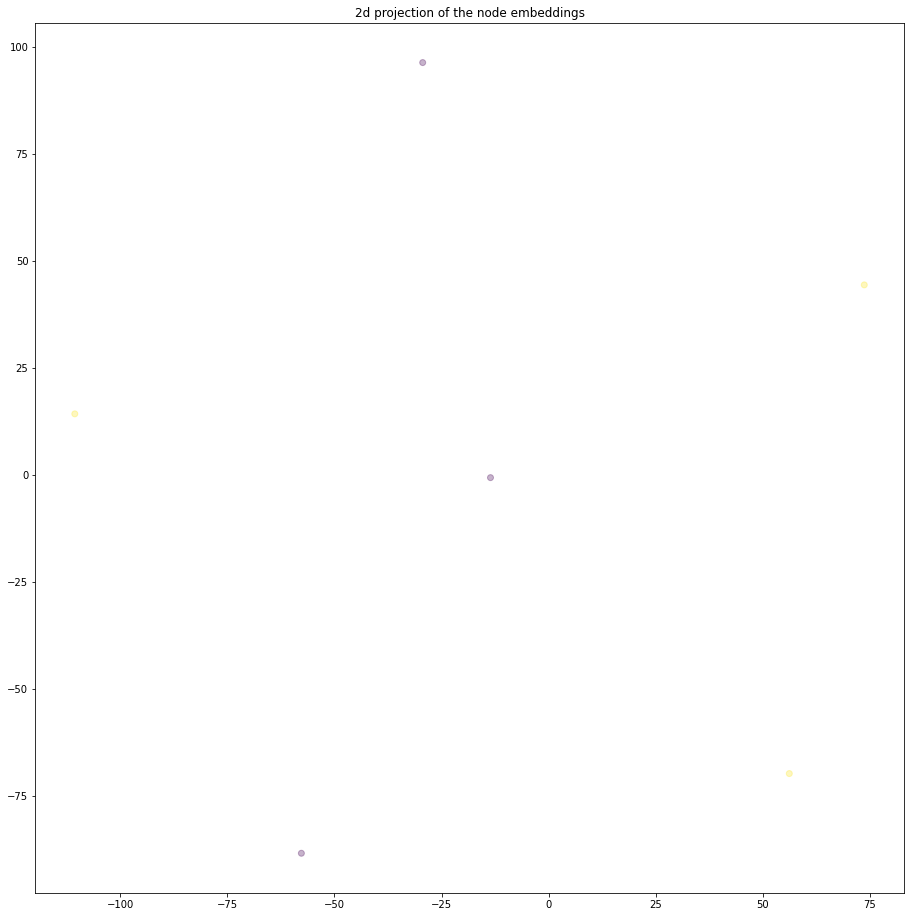

In [42]:
# viz

node_embeddings = model.wv.vectors
node_types = [G.node_type(node_id) for node_id in model.wv.index_to_key]

from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt


node_embeddings_2d = TSNE(n_components=2, learning_rate='auto').fit_transform(node_embeddings)
node_embeddings_2d

label_map = {l: i for i, l in enumerate(np.unique(node_types))}
node_colors = [label_map[t] for t in node_types]

plt.figure(figsize=(20, 16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=node_colors, alpha=0.3)
plt.title('2d projection of the node embeddings')
plt.show()